## Current Dataset

In [1]:
import ast
import pandas as pd

from collections import defaultdict

df = pd.read_csv('data/wikipedia.csv')

In [2]:
df.head()

,Unnamed: 0,title,url,cleanup_message,categories
0,0,Dorothea Brande,https://en.wikipedia.org/wiki/Dorothea_Brande,This article has multiple issues. Please help ...,"['Illinois Institute of Technology alumni', '1..."
1,1,Dorothea Brande,https://en.wikipedia.org/wiki/Dorothea_Brande,This article may need to be rewritten to compl...,"['Illinois Institute of Technology alumni', '1..."
2,2,Dorothea Brande,https://en.wikipedia.org/wiki/Dorothea_Brande,This article may be in need of reorganization ...,"['Illinois Institute of Technology alumni', '1..."
3,3,Dorothea Brande,https://en.wikipedia.org/wiki/Dorothea_Brande,This article contains a list that has not been...,"['Illinois Institute of Technology alumni', '1..."
4,4,DisplayPort,https://en.wikipedia.org/wiki/DisplayPort,This article may be too technical for most rea...,"['Digital display connectors', 'VESA', 'Comput..."


In [3]:
df.size

11480

In [4]:
# Part 1: title + url + cleanup_message
df_cleanup = df[['url', 'cleanup_message']].drop_duplicates()
df_cleanup.head()

,url,cleanup_message
0,https://en.wikipedia.org/wiki/Dorothea_Brande,This article has multiple issues. Please help ...
1,https://en.wikipedia.org/wiki/Dorothea_Brande,This article may need to be rewritten to compl...
2,https://en.wikipedia.org/wiki/Dorothea_Brande,This article may be in need of reorganization ...
3,https://en.wikipedia.org/wiki/Dorothea_Brande,This article contains a list that has not been...
4,https://en.wikipedia.org/wiki/DisplayPort,This article may be too technical for most rea...


In [5]:
grouped_df = (
    df.groupby(['url'], as_index=False)
      .agg({
          'cleanup_message': lambda msgs: list(set(msgs))  # deduplicate messages
      })
)

# Optional: sort the messages or categories if you want consistency
grouped_df['cleanup_message'] = grouped_df['cleanup_message'].apply(sorted)
grouped_df.head()

,url,cleanup_message
0,https://en.wikipedia.org/wiki/%C3%89cole_de_ma...,[This article may have been created or edited ...
1,https://en.wikipedia.org/wiki/%C3%93_h%C3%81dh...,[This article may contain unverified or indisc...
2,https://en.wikipedia.org/wiki/%C4%90inh_Xu%C3%...,[This section may contain unverified or indisc...
3,https://en.wikipedia.org/wiki/2008_UCF_Knights...,[This section may contain unverified or indisc...
4,https://en.wikipedia.org/wiki/2015_in_Philippi...,[Some of this article's listed sources may not...


In [6]:
grouped_df = grouped_df.drop_duplicates(subset=['url'])

In [7]:
grouped_df.size

1800

In [8]:
# Part 2: title + url + categories
df_categories = df[['url', 'categories']].drop_duplicates(subset=['url'])
df_categories.head()

,url,categories
0,https://en.wikipedia.org/wiki/Dorothea_Brande,"['Illinois Institute of Technology alumni', '1..."
4,https://en.wikipedia.org/wiki/DisplayPort,"['Digital display connectors', 'VESA', 'Comput..."
7,https://en.wikipedia.org/wiki/At%C3%ADnale_al_...,"['Las Estrellas original programming', 'The Pr..."
16,https://en.wikipedia.org/wiki/List_of_Dominica...,"['Lists of films by country of production', 'C..."
20,https://en.wikipedia.org/wiki/Instructional_de...,"['Applied psychology', 'Educational technology..."


In [9]:
df_categories.size

1800

In [10]:
df = pd.merge(grouped_df, df_categories, on=['url'], how='left')

## Check Clustering for 9 Topics

In [11]:
df['categories'] = df['categories'].apply(ast.literal_eval)

In [12]:
distinct_values = set(val for sublist in df['categories'] for val in sublist)

print(distinct_values)

{'American music educators', 'Norwegian video game composers', 'Television series by Brown Bag Films', 'Water rides', "1990s American children's television series", 'Post–civil rights era in African-American history', 'Lists of expatriate association football players', '1982 births', 'Politics of Moldova', 'Natural law ethicists', 'Social dance', 'Culture of Finland', 'Manga series', 'Noble titles of Egypt', 'Shogakukan franchises', 'Male actors from Gravesend, Kent', 'Ian Cussick songs', 'Writers from Oklahoma', 'Cryptography', 'Rail lines receiving land grants', 'Newspapers established in 1916', 'California Community Colleges', 'Sewing equipment', 'Knife manufacturing companies', 'United States health-related lists', 'South Korean television actresses', 'Slavery in South America', 'Gaelic games clubs in Dublin (city)', 'Boston College faculty', 'English science writers', 'Smoking cessation', 'Television in the Philippines by year', 'Almshouses in the United Kingdom', 'University of H

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rheyannmagcalas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Top words per topic:
Topic 1: university alumni faculty establishments school state california college railroads
Topic 2: writers american 20thcentury people lists male german english places
Topic 3: new colleges universities york culture city state summer births
Topic 4: people lists songs county academics roman catholic irish programming
Topic 5: based organizations society french organisations fellows australia north terrorist
Topic 6: district cities towns american philosophers clubs established establishments schools
Topic 7: companies films established american academic video university music staff
Topic 8: male japanese american 21stcentury actors women voice film prefecture
Topic 9: television united states series american births deaths fiction childrens


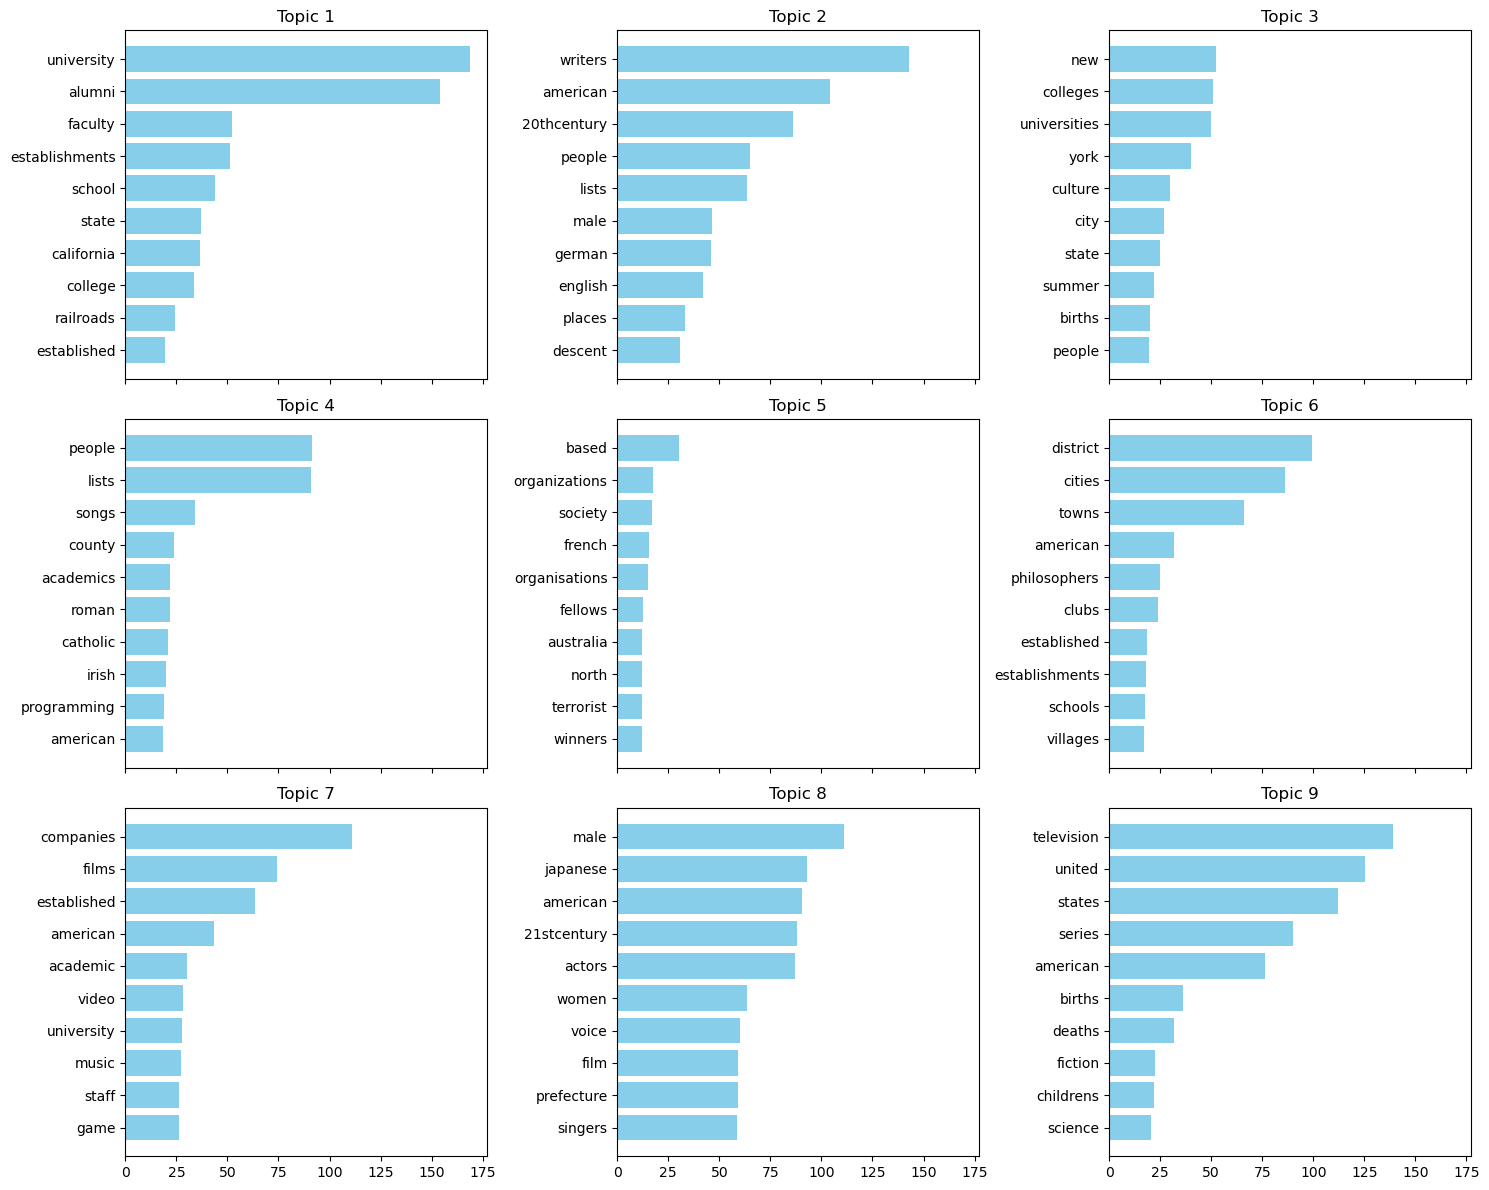

In [13]:
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk import download
import matplotlib.pyplot as plt
import numpy as np

# Download stopwords if needed
download('stopwords')
stop_words = set(stopwords.words('english'))

# Example: distinct_values is your list of category names
# categories = list(distinct_values)ß
# Simulated sample for demo
categories = list(distinct_values)

# 1️⃣ Clean each category
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[' + string.punctuation + r']', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

cleaned_categories = [clean_text(cat) for cat in categories]

# 2️⃣ Convert to document-term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(cleaned_categories)

# 3️⃣ Run LDA
lda = LatentDirichletAllocation(n_components=9, random_state=42)
lda.fit(X)

# 4️⃣ Print top words per topic
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}: ", end='')
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("\nTop words per topic:")
print_topics(lda, vectorizer.get_feature_names_out(), 9)

# 5️⃣ Bar chart visualization
def plot_top_words(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='skyblue')
        ax.set_title(f"Topic {topic_idx + 1}")
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

plot_top_words(lda, vectorizer.get_feature_names_out())

## Remarks:

| **LDA Topic** | **Top Words** (Simplified)                                  | **Mapped Category**             |
| ------------- | ----------------------------------------------------------- | ------------------------------- |
| **Topic 1**   | university, faculty, arts, media, california, state, school | **Science** or **Art**          |
| **Topic 2**   | writers, 20th century, people, lists, male, german, english | **Culture** or **History**      |
| **Topic 3**   | actors, colleges, voice, prefecture, york, universities     | **Culture** or **Art**          |
| **Topic 4**   | academics, political, railroads, league, record, births     | **Politics** or **History**     |
| **Topic 5**   | manga, olympics, roman, society, catholic, fellows          | **Culture**                     |
| **Topic 6**   | cities, towns, philosophers, villages, clubs                | **History** or **Environment**  |
| **Topic 7**   | companies, films, music, academic, video, game              | **Technology** or **Economics** |
| **Topic 8**   | women, japanese, singers, composers, film, 21st century     | **Art**                         |
| **Topic 9**   | television, series, united states, songs, childrens         | **Culture** or **Art**          |


* Some topics naturally overlap multiple categories (e.g., Topic 1 touches both Science and Art).

* The app will allow multiple topic-category mappings behind the scenes but just show users the clean 9 categories.

## Modelling

In [14]:
df['text'] = df['categories'].apply(lambda cats: ' '.join(cats))

In [15]:
def clean_text(text):
    text = text.lower()
    text = re.sub(rf"[{string.punctuation}]", " ", text)
    text = re.sub(r"\d+", "", text)
    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return " ".join(words)

In [16]:
df['cleaned'] = df['text'].apply(clean_text)

In [17]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['cleaned'])

# LDA modeling
lda = LatentDirichletAllocation(n_components=9, random_state=42)
lda.fit(X)
topic_distributions = lda.transform(X)

In [18]:
topic_to_categories = {
    0: ["Science", "Art"],
    1: ["Culture", "History"],
    2: ["Art", "Culture"],
    3: ["Politics", "History"],
    4: ["Culture", "Art"],
    5: ["History", "Environment"],
    6: ["Technology", "Economics"],
    7: ["Art", "Culture"],
    8: ["Culture", "Art"]
}


# Get topic distribution for each row
topic_distributions = lda.transform(X) 

In [19]:
def map_topics_to_categories(topic_dist, topic_to_cat_map):
    cat_weights = defaultdict(float)
    for topic_idx, topic_weight in enumerate(topic_dist):
        cats = topic_to_cat_map.get(topic_idx, [])
        for cat in cats:
            cat_weights[cat] += topic_weight / len(cats)  # equally split topic weight
    total = sum(cat_weights.values())
    if total > 0:
        cat_percentages = {k: round(v / total * 100, 2) for k, v in cat_weights.items()}
    else:
        cat_percentages = {}
    return cat_percentages

# Add category percentages column to dataframe
df['category_percentages'] = [map_topics_to_categories(dist, topic_to_categories) for dist in topic_distributions]

In [22]:
def get_main_category(cat_perc_dict):
    if not cat_perc_dict:
        return None
    return max(cat_perc_dict, key=cat_perc_dict.get)

df['main_category'] = df['category_percentages'].apply(get_main_category)

# Show final dataframe
display(df[['url', 'categories', 'category_percentages', 'main_category']].drop_duplicates(subset=['url']))

,url,categories,category_percentages,main_category
0,https://en.wikipedia.org/wiki/%C3%89cole_de_ma...,"[Grandes écoles, Business schools in France, U...","{'Science': 0.35, 'Art': 48.61, 'Culture': 48....",Art
1,https://en.wikipedia.org/wiki/%C3%93_h%C3%81dh...,"[Surnames, Irish clans, Irish-language masculi...","{'Science': 0.43, 'Art': 48.29, 'Culture': 48....",Art
2,https://en.wikipedia.org/wiki/%C4%90inh_Xu%C3%...,"[Vietnamese writers, Vietnamese male poets, 19...","{'Science': 0.31, 'Art': 1.54, 'Culture': 31.9...",History
3,https://en.wikipedia.org/wiki/2008_UCF_Knights...,"[2008 Conference USA football season, UCF Knig...","{'Science': 0.43, 'Art': 24.34, 'Culture': 24....",History
4,https://en.wikipedia.org/wiki/2015_in_Philippi...,"[2015 in Philippine television, Television in ...","{'Science': 0.56, 'Art': 17.78, 'Culture': 17....",History
...,...,...,...,...
895,https://en.wikipedia.org/wiki/Yurina_Kumai,"[1993 births, Living people, Berryz Kobo membe...","{'Science': 48.73, 'Art': 49.37, 'Culture': 0....",Art
896,https://en.wikipedia.org/wiki/Yuuki_Matsuda,"[81 Produce voice actors, Japanese male video ...","{'Science': 48.61, 'Art': 49.31, 'Culture': 0....",Art
897,https://en.wikipedia.org/wiki/Yuya_Matsushita,"[1990 births, Japanese male film actors, Japan...","{'Science': 38.32, 'Art': 38.81, 'Culture': 0....",Art
898,https://en.wikipedia.org/wiki/Zamira_Ismailovn...,"[Uzbekistani women archaeologists, Uzbekistani...","{'Science': 0.56, 'Art': 2.78, 'Culture': 47.7...",Culture


In [27]:
df[['url', 'categories', 'category_percentages', 'main_category', 'cleanup_message']].drop_duplicates(subset=['url']).to_csv('data/categories.csv',  index=False)

In [23]:
def relevance_score_dict(cat_pct_dict, selected_categories):
    score = 0
    for cat in selected_categories:
        score += cat_pct_dict.get(cat, 0)
    return score

## Testing Recommendations

In [24]:
user_selected_categories = ["Science", "Art"]

df['relevance'] = df['category_percentages'].apply(lambda d: relevance_score_dict(d, user_selected_categories))

recommended = df[df['relevance'] > 0].sort_values(by='relevance', ascending=False)

display(recommended[['url', 'categories', 'category_percentages', 'relevance']].head(30))

,url,categories,category_percentages,relevance
273,https://en.wikipedia.org/wiki/Hiroshi_Kamiya,"[1975 births, Living people, Aoni Production v...","{'Science': 49.27, 'Art': 49.64, 'Culture': 0....",98.91
164,https://en.wikipedia.org/wiki/Daisuke_Kishio,"[1974 births, Living people, Aoni Production v...","{'Science': 49.21, 'Art': 49.6, 'Culture': 0.5...",98.81
166,https://en.wikipedia.org/wiki/Daisuke_Ono,"[1978 births, Living people, Best Actor Seiyu ...","{'Science': 49.21, 'Art': 49.6, 'Culture': 0.5...",98.81
355,https://en.wikipedia.org/wiki/Kenichi_Suzumura,"[1974 births, Living people, 20th-century Japa...","{'Science': 49.07, 'Art': 49.54, 'Culture': 0....",98.61
562,https://en.wikipedia.org/wiki/Momoko_Tsugunaga,"[1992 births, Berryz Kobo members, People from...","{'Science': 48.99, 'Art': 49.49, 'Culture': 0....",98.48
710,https://en.wikipedia.org/wiki/Saki_Shimizu,"[1991 births, Living people, Singers from Toky...","{'Science': 48.94, 'Art': 49.47, 'Culture': 0....",98.41
542,https://en.wikipedia.org/wiki/Masashi_Ebara,"[1953 births, Living people, Aoni Production v...","{'Science': 48.92, 'Art': 49.46, 'Culture': 0....",98.38
596,https://en.wikipedia.org/wiki/Nobuhiko_Okamoto,"[1986 births, Living people, Japanese male pop...","{'Science': 48.89, 'Art': 49.44, 'Culture': 0....",98.33
265,https://en.wikipedia.org/wiki/Hidekatsu_Shibata,"[1937 births, Living people, Aoni Production v...","{'Science': 48.83, 'Art': 49.41, 'Culture': 0....",98.24
777,https://en.wikipedia.org/wiki/T%C5%8Dru_%C5%8C...,"[1968 births, Living people, Japanese male sta...","{'Science': 48.8, 'Art': 49.4, 'Culture': 0.75...",98.20
